## Baseline Solution for [Seismic Facies Identification Challenge](https://www.aicrowd.com/challenges/seismic-facies-identification-challenge/leaderboards)

### We used **U-Net** model whose architecture is shown below

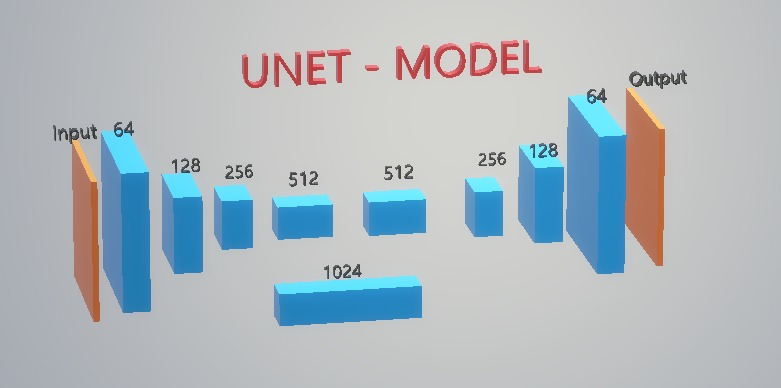

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F

# DoubleConv Class to perform two layer Convolution
class DoubleConv(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(DoubleConv,self).__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(in_ch,out_ch,3,padding=1), 
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace = True),
                nn.Conv2d(out_ch,out_ch,3,padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace = True)
            )
    def forward(self,x):
        return self.conv(x)
# Unter Class with shown architecture
class UNet(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(UNet,self).__init__()
        self.conv1 = DoubleConv(in_ch,64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64,128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128,256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256,512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512,1024)
        self.up6 = nn.ConvTranspose2d(1024,512,2,stride=2)
        self.conv6 = DoubleConv(1024,512)
        self.up7 = nn.ConvTranspose2d(512,256,2,stride=2)
        self.conv7 = DoubleConv(512,256)
        self.up8 = nn.ConvTranspose2d(256,128,2,stride=2)
        self.conv8 = DoubleConv(256,128)
        self.up9 = nn.ConvTranspose2d(128,64,2,stride=2)
        self.conv9 = DoubleConv(128,128)
        self.conv9 = DoubleConv(128,64)
        self.conv10 = nn.Conv2d(64,out_ch,1)

    def forward(self,x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6,c4],dim=1)
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7,c3],dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8,c2],dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9,c1],dim=1)
        c9 = self.conv9(merge9)
        out = c9
        c10 = self.conv10(c9)
        out = c10        
        out = nn.Softmax()(c10) 
        return out

### Data Download

In [ ]:
# Getting the Data files from the aicrowd website
!wget https://datasets.aicrowd.com/default/aicrowd-public-datasets/seamai-facies-challenge/v0.1/public/data_train.npz
!wget https://datasets.aicrowd.com/default/aicrowd-public-datasets/seamai-facies-challenge/v0.1/public/data_test_1.npz
!wget https://datasets.aicrowd.com/default/aicrowd-public-datasets/seamai-facies-challenge/v0.1/public/labels_train.npz

#### If we look at the Train and the Test data we can observe that their shapes are different, So we decided to follow the Slice and Stack approach to make it nearly similar to the Test Data 
#### (Look at the Below figure to understand)

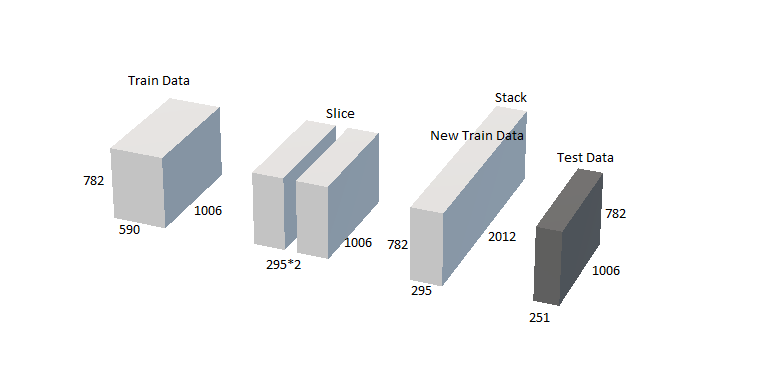

### Data Handling

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset#
from torch import optim

import numpy as np
sei_patch = np.load('/content/data_train.npz')['data']
lab_patch = np.load('/content/labels_train.npz')['labels']

import cv2
from tqdm.notebook import tqdm
import datetime 
from IPython.display import HTML
import cv2


sei_patch = np.concatenate((sei_patch[:,:,:295] , sei_patch[:,:,295:]))
lab_patch = np.concatenate((lab_patch[:,:,:295] , lab_patch[:,:,295:]))
sei_patch.shape, lab_patch.shape

((2012, 782, 295), (2012, 782, 295))

### Resizing the images Considering the Computational power

In [ ]:
training_img_data = []
training_label_data = []

for i in tqdm(range(0, 2012)):
  img = sei_patch[i,:,:]
  label = lab_patch[i,:,:]

  img = np.expand_dims(img, axis=2).astype('float32')
  label = np.expand_dims(label, axis=2).astype('float32')

  img = cv2.resize(img, (256,256 ))
  label = cv2.resize(label, ( 256,256))

  training_img_data.append(img) 
  training_label_data.append(label)

training_img_data = np.asarray(training_img_data)
training_label_data = np.asarray(training_label_data)
training_label_data = np.array(training_label_data,dtype=int)
training_img_data.shape, training_label_data.shape

((2012, 256, 256), (2012, 256, 256))

### Creating a DataGenerator Class along with Metrics and Train Function

In [ ]:
class DataGenerator(Dataset):
    def __init__(self, x_set, y_set):
        self.x, self.y = x_set, y_set

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        batch_x = self.x[index]
        batch_y = self.y[index]
        return np.expand_dims(batch_x,axis=0), batch_y

e=1e-2

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()


def train(model,optimizer,dataload,num_epochs,device):
    acc_history  = []
    loss_history = []
    miou_history = []
    for epoch in range(num_epochs):
        print('Starting epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        since = time.time()
        dataset_size = len(dataload.dataset)
        epoch_loss = 0
        epoch_acc  = 0

        for idx,(x, y) in enumerate(dataload):                 
            optimizer.zero_grad()             
            inputs = x.to(device)
            labels = y.to(device)
            outputs = model(inputs)           
            criterion1 = MulticlassDiceLoss() 
            loss1 = criterion1(outputs,labels.long())
            criterion2 = torch.nn.CrossEntropyLoss()
            loss2 = criterion2(torch.log(outputs),labels.long())
            loss = e*loss1+loss2
            acc  = accuracy(outputs,labels)
            loss.backward()                  
            optimizer.step()                  
            
            epoch_loss += loss.item()
            epoch_acc+= acc
            loss_history.append(loss.item())
            acc_history.append(acc)
            if (idx+1)%10==0:
              print("%d/%d,train_loss:%0.3f,accuracy:%0.3f" % (idx+1, dataset_size // dataload.batch_size, loss.item(),acc))

        time_elapsed = time.time() - since     
        all_epoch_loss=epoch_loss/len(dataload)
        all_epoch_acc=epoch_acc/len(dataload)
        print("epoch %d loss:%0.3f accuracy:%0.3f " % (epoch, all_epoch_loss,all_epoch_acc))
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    torch.save(model,"/content/model_0.pth")      
    return model,loss_history,acc_history

### Data Loading and Model Training

In [ ]:
from dice_loss import *
!CUDA_LAUNCH_BLOCKING=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(1,7).to(device)
train_dataset = DataGenerator(x_set=training_img_data,y_set=training_label_data) 
dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
optimizer = optim.Adam(model.parameters(),lr=1e-4)
num_epochs=12

model_0,loss,acc=train(model,optimizer,dataloader,num_epochs,device)

Starting epoch 1/12
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


10/201,train_loss:2.073,accuracy:0.211
20/201,train_loss:1.849,accuracy:0.339
30/201,train_loss:1.520,accuracy:0.538
40/201,train_loss:1.539,accuracy:0.506
50/201,train_loss:1.597,accuracy:0.461
60/201,train_loss:1.550,accuracy:0.508
70/201,train_loss:1.272,accuracy:0.652
80/201,train_loss:1.069,accuracy:0.780
90/201,train_loss:1.375,accuracy:0.585
100/201,train_loss:1.562,accuracy:0.537
110/201,train_loss:1.281,accuracy:0.626
120/201,train_loss:1.114,accuracy:0.743
130/201,train_loss:1.379,accuracy:0.597
140/201,train_loss:1.265,accuracy:0.555
150/201,train_loss:1.633,accuracy:0.541
160/201,train_loss:1.098,accuracy:0.694
170/201,train_loss:1.064,accuracy:0.709
180/201,train_loss:1.111,accuracy:0.678
190/201,train_loss:0.999,accuracy:0.734
200/201,train_loss:1.140,accuracy:0.678
epoch 0 loss:1.421 accuracy:0.567 
Training complete in 1m 53s
Starting epoch 2/12
----------
10/201,train_loss:1.276,accuracy:0.576
20/201,train_loss:1.067,accuracy:0.680
30/201,train_loss:1.597,accuracy:0.46

In [ ]:
## Function to predict
def seisfacies_predict(section,patch_size=256,overlap=0,onehot=0): 
    m1,m2 = section.shape
    os    = overlap                                 
    n1,n2 = patch_size,patch_size             
    c1 = int(np.round((m1+os)/(n1-os)+0.5))
    c2 = int(np.round((m2+os)/(n2-os)+0.5))
    p1 = (n1-os)*c1+os
    p2 = (n2-os)*c2+os

    gp = np.zeros((p1,p2),dtype=np.single)     
    gy = np.zeros((7,p1,p2),dtype=np.single)    
    gs = np.zeros((n1,n2),dtype=np.single) 
    
    gp[0:m1,0:m2]=section     

    for k1 in range(c1):
        for k2 in range(c2):
            b1 = k1*n1-k1*os
            e1 = b1+n1
            b2 = k2*n2-k2*os
            e2 = b2+n2                
            #predict
            gs[:,:]=gp[b1:e1,b2:e2]
            x=gs.reshape(1,1,256,256)
            Y_patch= model(torch.from_numpy(x)).squeeze()
            p=F.softmax(Y_patch, dim=0).detach().numpy()
            gy[:,b1:e1,b2:e2]= gy[:,b1:e1,b2:e2]+p
    
    gy_onehot = gy[:,0:m1,0:m2]            
    #onehot2label
    gy_label =np.argmax(gy_onehot,axis=0)

    if onehot==0:
        return gy_label
    if onehot==1:
        return gy_label,gy_onehot

### Loading Test Data

In [ ]:
test_seismic = np.load('/content/data_test_1.npz')['data']
testing_img_data = []
for i in tqdm(range(0, 1006)):
  img = test_seismic[i,:,:]
  img = np.expand_dims(img, axis=2).astype('float32')
  img = cv2.resize(img, (256, 256))
  testing_img_data.append(img) 
  
testing_img_data = np.asarray(testing_img_data)


### Testing Predictions for One Data

In [ ]:
#loading the Saved Model
model = torch.load("model_0.pth",map_location='cpu')
gy_label,gy_onehot=seisfacies_predict(training_img_data[180],onehot=1)
gy_label

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 6, 6, ..., 2, 2, 2],
       ...,
       [6, 6, 6, ..., 4, 4, 4],
       [6, 6, 6, ..., 4, 4, 4],
       [2, 6, 6, ..., 4, 4, 4]])

In [ ]:
training_label_data[180]

array([[6, 6, 6, ..., 2, 2, 2],
       [6, 6, 6, ..., 2, 2, 2],
       [6, 6, 6, ..., 2, 2, 2],
       ...,
       [6, 6, 6, ..., 4, 4, 4],
       [6, 6, 6, ..., 4, 4, 4],
       [6, 6, 6, ..., 4, 4, 4]])

### Predictions

In [ ]:
preds = []
for i in tqdm(range(0, 1006)):
  gy_label,gy_onehot=seisfacies_predict(testing_img_data[i],onehot=1)
  label = gy_label
  label = np.expand_dims(label, axis=2).astype('float32')
  label = cv2.resize(label, (251,782))
  preds.append(label)

In [ ]:
final_preds = np.asarray(preds)
final_preds = np.array(final_preds,dtype=int)

In [ ]:
np.savez_compressed('submission.npz', prediction = final_preds)